In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import ks_2samp
import pickle

### In this Notebook, what I do is filter the samples using a linear regression applied to the distribution of Wolf-Rayet stars in Color-Color spaces, then I apply a Kolmogorov-Smirnov test to ensure that the sample used as non-Wolf-Rayet is as similar as possible to these potential ones. Subsequently, I plot the results.

In [3]:
muestrac = pd.read_csv('Archivos/Muestra4/estrellas_clasificadas.csv')
wolfr = pd.read_csv('Archivos/Crowther/catalogo_entrenamiento_filtradototal.csv')

In [11]:
muestrac.shape

(229249, 256)

In [12]:
wolfr.shape

(281, 325)

In [13]:
print('Muestra columnas: ', list(muestrac.columns))
print('Wolfr columnas: ', list(wolfr.columns))

Muestra columnas:  ['source_id', 'solution_id', 'designation', 'source_id.1', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_t

In [14]:
wolfr = wolfr[wolfr['parallax'] >= 0]
wolfr.shape

(281, 325)

In [15]:
nan_por_columna = muestrac.isna().sum()
print("Cantidad de NaN por columna:")
for columna, cantidad in nan_por_columna.items():
    print(f"{columna}: {cantidad}")

Cantidad de NaN por columna:
source_id: 0
solution_id: 0
designation: 0
source_id.1: 0
random_index: 0
ref_epoch: 0
ra: 0
ra_error: 0
dec: 0
dec_error: 0
parallax: 0
parallax_error: 0
parallax_over_error: 0
pm: 0
pmra: 0
pmra_error: 0
pmdec: 0
pmdec_error: 0
ra_dec_corr: 0
ra_parallax_corr: 0
ra_pmra_corr: 0
ra_pmdec_corr: 0
dec_parallax_corr: 0
dec_pmra_corr: 0
dec_pmdec_corr: 0
parallax_pmra_corr: 0
parallax_pmdec_corr: 0
pmra_pmdec_corr: 0
astrometric_n_obs_al: 0
astrometric_n_obs_ac: 0
astrometric_n_good_obs_al: 0
astrometric_n_bad_obs_al: 0
astrometric_gof_al: 0
astrometric_chi2_al: 0
astrometric_excess_noise: 0
astrometric_excess_noise_sig: 0
astrometric_params_solved: 0
astrometric_primary_flag: 0
nu_eff_used_in_astrometry: 9370
pseudocolour: 219879
pseudocolour_error: 219879
ra_pseudocolour_corr: 219879
dec_pseudocolour_corr: 219879
parallax_pseudocolour_corr: 219879
pmra_pseudocolour_corr: 219879
pmdec_pseudocolour_corr: 219879
astrometric_matched_transits: 0
visibility_period

# Vamos a hacer la regresion lineal

In [24]:
colores = [
    'Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp',
    'Jmag-Hmag', 'Jmag-Kmag', 'Hmag-Kmag',
    'W1-W2'
]

def signed_log_transform(x):
    """
    Aplica una transformación logarítmica signada a un array de numpy.
    
    Parámetros:
    - x: array-like, datos a transformar.
    
    Retorna:
    - array de datos transformados.
    """
    return np.sign(x) * np.log1p(np.abs(x))

def invertir_signed_log_transform(y):
    """
    Invierte la transformación logarítmica signada.
    
    Parámetros:
    - y: array-like, datos transformados.
    
    Retorna:
    - array de datos originales aproximados.
    """
    return np.sign(y) * (np.expm1(np.abs(y)))

def ajustar_y_filtrar_signed_log(x_col, y_col, wolfr, muestrac, sigma_factor=sigma_factor):
    X_wolfr_log = signed_log_transform(wolfr[x_col].values.reshape(-1, 1))
    Y_wolfr_log = signed_log_transform(wolfr[y_col].values)
    
    model = LinearRegression()
    model.fit(X_wolfr_log, Y_wolfr_log)
    
    Y_pred_log = model.predict(X_wolfr_log)
    residuals_log = Y_wolfr_log - Y_pred_log
    sigma_log = np.std(residuals_log)
    
    X_muestra_log = signed_log_transform(muestrac[x_col].values.reshape(-1, 1))
    Y_muestra_log = signed_log_transform(muestrac[y_col].values)
    Y_pred_muestra_log = model.predict(X_muestra_log)
    mask_muestra_partial = (Y_muestra_log >= Y_pred_muestra_log - sigma_factor*sigma_log) & \
                           (Y_muestra_log <= Y_pred_muestra_log + sigma_factor*sigma_log)
    
    mask_muestra = pd.Series(mask_muestra_partial, index=muestrac.index)
    
    Y_pred_wolfr_log = model.predict(X_wolfr_log)
    mask_wolfr_partial = (Y_wolfr_log >= Y_pred_wolfr_log - sigma_factor*sigma_log) & \
                         (Y_wolfr_log <= Y_pred_wolfr_log + sigma_factor*sigma_log)
    
    mask_wolfr = pd.Series(mask_wolfr_partial, index=wolfr.index)
    
    return model, sigma_log, mask_muestra, mask_wolfr

sigma_factor = 2

mask_final_muestra = pd.Series([True] * len(muestrac), index=muestrac.index)
mask_final_wolfr = pd.Series([True] * len(wolfr), index=wolfr.index)

limits_dict = {}

catalogos = {
    'Gaia': ['Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp'],
    '2MASS': ['Jmag-Hmag', 'Jmag-Kmag', 'Hmag-Kmag']
}


os.makedirs('Archivos/Muestra4', exist_ok=True)
os.makedirs('Graficos/color-color filtros', exist_ok=True)
os.makedirs('Archivos/Muestra final', exist_ok=True)

for catalogo, colores_catalogo in catalogos.items():
    for i in range(len(colores_catalogo)):
        for j in range(i + 1, len(colores_catalogo)):
            x_col = colores_catalogo[i]
            y_col = colores_catalogo[j]

            model, sigma_log, mask_muestra, mask_wolfr = ajustar_y_filtrar_signed_log(
                x_col, y_col, wolfr, muestrac, sigma_factor=sigma_factor
            )

            mask_final_muestra &= mask_muestra
            mask_final_wolfr &= mask_wolfr
            plt.figure(figsize=(10, 7))
            plt.scatter(muestrac[x_col], muestrac[y_col], color='pink', label='Muestra Representativa', alpha=0.3)
            plt.scatter(muestrac[mask_muestra][x_col], muestrac[mask_muestra][y_col], color='red', label='Muestra Filtrada', alpha=0.7)
            plt.scatter(wolfr[x_col], wolfr[y_col], color='teal', label='Wolf-Rayet', alpha=0.3)
            plt.scatter(wolfr[mask_wolfr][x_col], wolfr[mask_wolfr][y_col], color='blue', label='Wolf-Rayet Filtrada', alpha=0.7)

            X_wolfr = wolfr[x_col]
            X_range = np.linspace(X_wolfr.min(), X_wolfr.max(), 1000).reshape(-1, 1)
            X_range_log = signed_log_transform(X_range)
            Y_pred_log = model.predict(X_range_log)
            Y_pred = invertir_signed_log_transform(Y_pred_log)

            plt.plot(X_range, Y_pred, color='black', label='Regresión Lineal')

  
            upper_limit_log = Y_pred_log + sigma_factor * sigma_log
            lower_limit_log = Y_pred_log - sigma_factor * sigma_log
            upper_limit = invertir_signed_log_transform(upper_limit_log)
            lower_limit = invertir_signed_log_transform(lower_limit_log)
            plt.fill_between(X_range.flatten(), lower_limit, upper_limit, color='gray', alpha=0.2, label=f'±{sigma_factor}σ')

            key = (catalogo, x_col, y_col)
            limits_dict[key] = {
                'X_range': X_range.flatten(),
                'Y_pred': Y_pred,
                'upper_limit': upper_limit,
                'lower_limit': lower_limit,
                'model': model,
                'sigma_log': sigma_log
            }

            plt.xlabel(x_col)
            plt.ylabel(y_col)
            plt.legend()
            plt.title(f'{catalogo}: {x_col} vs {y_col}')
            plt.savefig(f'Graficos/color-color filtros/grafico_{catalogo}_{x_col}_vs_{y_col}.png')
            plt.close()


muestrac_filtrada_final = muestrac[mask_final_muestra]
wolfr_filtrada_final = wolfr[mask_final_wolfr]

muestrac_filtrada_final.to_csv('Archivos/Muestra4/muestra_rgl.csv', index=False)
wolfr_filtrada_final.to_csv('Archivos/Muestra4/wolfr_rgl.csv', index=False)

with open('Archivos/Muestra final/limits_dict.pkl', 'wb') as f:
    pickle.dump(limits_dict, f)

print(f"Muestra representativa original: {len(muestrac)}")
print(f"Muestra representativa filtrada: {len(muestrac_filtrada_final)}")
print(f"Wolf-Rayet original: {len(wolfr)}")
print(f"Wolf-Rayet filtrada: {len(wolfr_filtrada_final)}")
print("Límites guardados en 'Archivos/Muestra final/limits_dict.pkl'")


Muestra representativa original: 229249
Muestra representativa filtrada: 23434
Wolf-Rayet original: 281
Wolf-Rayet filtrada: 240
Límites guardados en 'Archivos/Muestra final/limits_dict.pkl'


In [25]:

with open('Archivos/Muestra final/limits_dict.pkl', 'rb') as f:
    limits_dict = pickle.load(f)

sigma_factor = 2

parquet_files = glob.glob('Archivos/Muestra4/parquet/processed_*.parquet')

os.makedirs('Archivos/Muestra4/parquet/filtrados', exist_ok=True)

for file_path in parquet_files:
    df_chunk = pd.read_parquet(file_path)
    
    mask_final_chunk = pd.Series([True]*len(df_chunk), index=df_chunk.index)
    

    for (catalogo, x_col, y_col), params in limits_dict.items():
        model = params['model']
        sigma_log = params['sigma_log']
        

        X_chunk_log = signed_log_transform(df_chunk[x_col].values.reshape(-1, 1))
        Y_chunk_log = signed_log_transform(df_chunk[y_col].values)
        

        Y_pred_chunk_log = model.predict(X_chunk_log)
        

        chunk_condition = (Y_chunk_log >= Y_pred_chunk_log - sigma_factor*sigma_log) & \
                          (Y_chunk_log <= Y_pred_chunk_log + sigma_factor*sigma_log)
        

        mask_filter = pd.Series(chunk_condition, index=df_chunk.index)
        

        mask_final_chunk &= mask_filter
    

    df_chunk_filtrado = df_chunk[mask_final_chunk]
    

    file_name = os.path.basename(file_path).replace('.parquet', '_filtrado.parquet')
    df_chunk_filtrado.to_parquet(os.path.join('Archivos/Muestra4/parquet/filtrados', file_name), index=False)
    
    print(f"Filtrado guardado: {file_name}, {len(df_chunk_filtrado)} objetos.")

print("Filtrado de muestra completa finalizado.")


Filtrado guardado: processed_0_filtrado.parquet, 120617 objetos.
Filtrado guardado: processed_1_filtrado.parquet, 115748 objetos.
Filtrado guardado: processed_10_filtrado.parquet, 252143 objetos.
Filtrado guardado: processed_11_filtrado.parquet, 257921 objetos.
Filtrado guardado: processed_12_filtrado.parquet, 223687 objetos.
Filtrado guardado: processed_13_filtrado.parquet, 182453 objetos.
Filtrado guardado: processed_14_filtrado.parquet, 151184 objetos.
Filtrado guardado: processed_15_filtrado.parquet, 125299 objetos.
Filtrado guardado: processed_16_filtrado.parquet, 111249 objetos.
Filtrado guardado: processed_17_filtrado.parquet, 104302 objetos.
Filtrado guardado: processed_18_filtrado.parquet, 97276 objetos.
Filtrado guardado: processed_19_filtrado.parquet, 94479 objetos.
Filtrado guardado: processed_2_filtrado.parquet, 117818 objetos.
Filtrado guardado: processed_20_filtrado.parquet, 95464 objetos.
Filtrado guardado: processed_21_filtrado.parquet, 97685 objetos.
Filtrado guardado

# Del total de la muestra clasificada ahora voy a obtener una muestra de entrenamiento la cual sea representativa del total de datos obtenidos de gaia, para esto corro un kmeans

In [27]:
muestrac = pd.read_csv('Archivos/Muestra4/muestra_rgl.csv')
wolfr = pd.read_csv('Archivos/Muestra4/wolfr_rgl.csv')

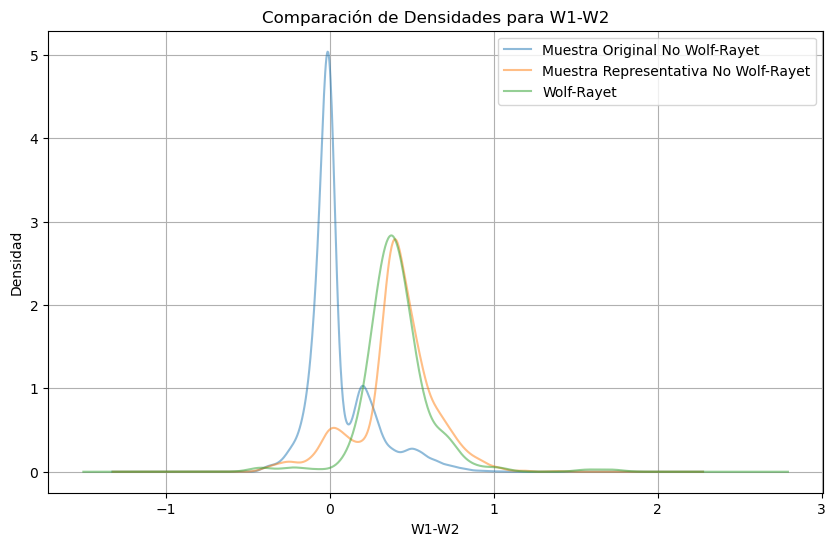

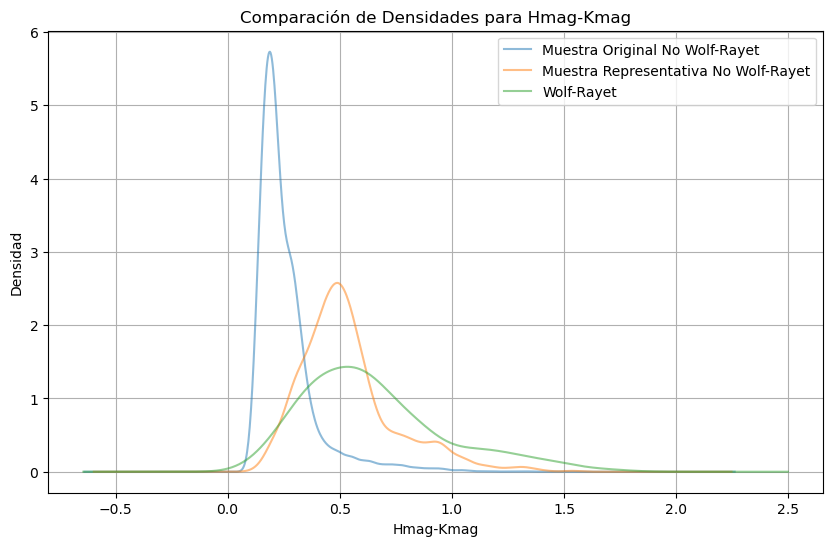

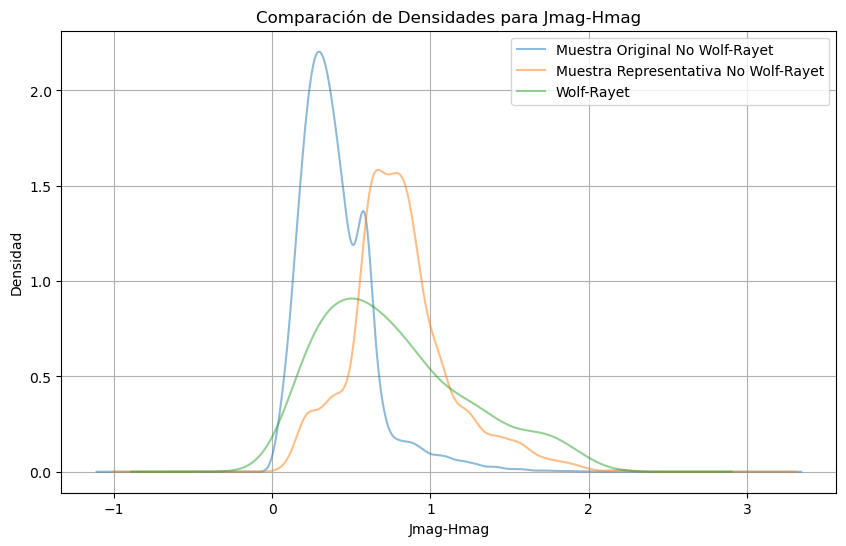

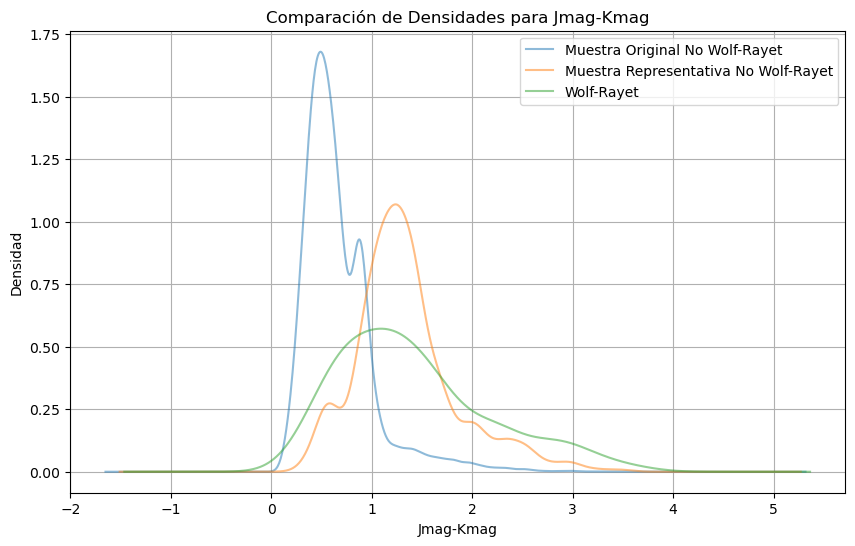

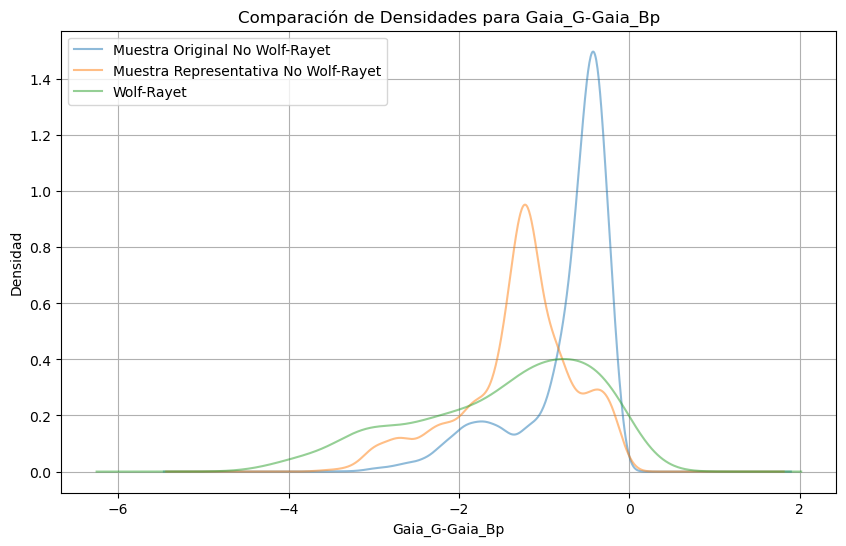

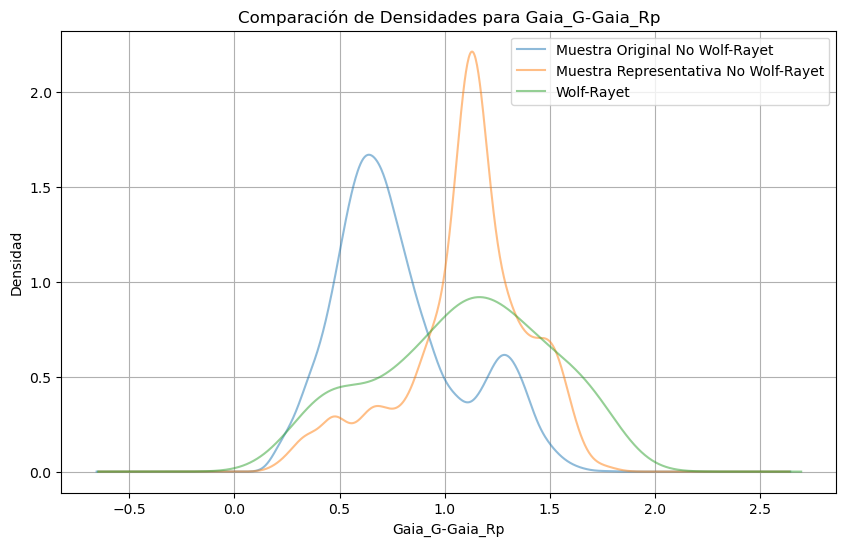

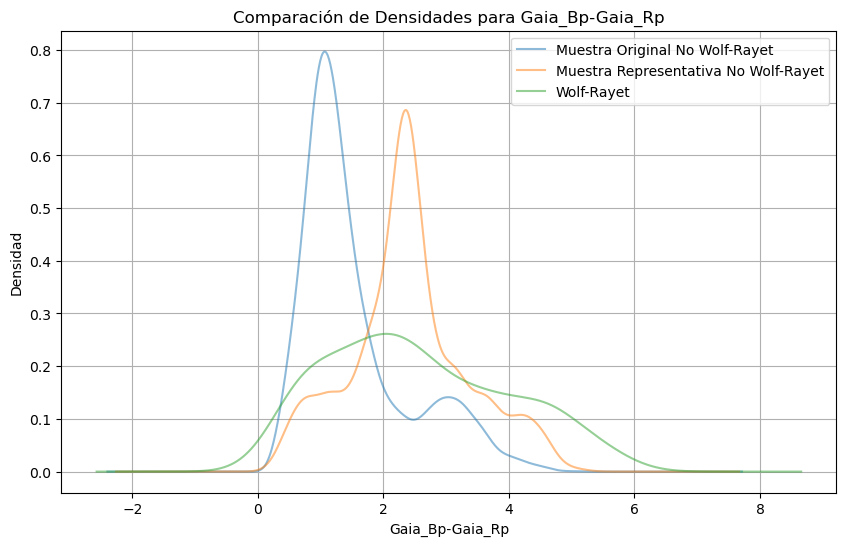

In [28]:


colores_conflictivos = ['W1-W2','Hmag-Kmag','Jmag-Hmag','Jmag-Kmag','Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp']
def seleccionar_muestra_representativa_por_intervalos(wolfr, muestrac, colores, tamano_muestra=1000, num_intervals=10):
    indices_seleccionados = []
    ks_stats_dict = {color: [] for color in colores}
    valores_wr_dict = {color: wolfr[color].dropna() for color in colores}
    valores_no_wr_dict = {color: muestrac[color].dropna() for color in colores}
    for color in colores:
        intervals = np.linspace(valores_wr_dict[color].min(), valores_wr_dict[color].max(), num_intervals+1)
        
        for i in range(num_intervals):
            mask_no_wr = (valores_no_wr_dict[color] >= intervals[i]) & (valores_no_wr_dict[color] < intervals[i+1])
            subset_no_wr = valores_no_wr_dict[color][mask_no_wr]

            if len(subset_no_wr) > 0:
                distancias = []
                for idx in subset_no_wr.index:
                    distancia_total = 0
                    for color_inner in colores:
                        valor_no_wr = valores_no_wr_dict[color_inner].get(idx)
                        if pd.notna(valor_no_wr):
                            ks_stat, _ = ks_2samp(valores_wr_dict[color_inner], [valor_no_wr])
                            distancia_total += ks_stat
                            ks_stats_dict[color_inner].append((idx, ks_stat))
                    distancias.append((idx, distancia_total))
                distancias_ordenadas = sorted(distancias, key=lambda x: x[1])
                indices_seleccionados.extend([idx for idx, _ in distancias_ordenadas[:tamano_muestra // num_intervals]])
    muestra_representativa = muestrac.loc[indices_seleccionados]
    
    with open('modelos/ks_stats_dict.pkl1', 'wb') as f:
        pickle.dump(ks_stats_dict, f)
    
    return muestra_representativa
muestra_no_wr_representativa = seleccionar_muestra_representativa_por_intervalos(wolfr, muestrac, colores_conflictivos)
muestra_no_wr_representativa.to_csv("Archivos/Muestra/muestra_entrenamiento1.csv", index=False)

for color in colores_conflictivos:
    plt.figure(figsize=(10, 6))
    muestrac[color].dropna().plot(kind='kde', label='Muestra Original No Wolf-Rayet', alpha=0.5)
    muestra_no_wr_representativa[color].dropna().plot(kind='kde', label='Muestra Representativa No Wolf-Rayet', alpha=0.5)
    
    wolfr[color].dropna().plot(kind='kde', label='Wolf-Rayet', alpha=0.5)
    
    plt.xlabel(color)
    plt.ylabel('Densidad')
    plt.title(f'Comparación de Densidades para {color}')
    plt.legend()
    plt.grid(True)
    plt.show()

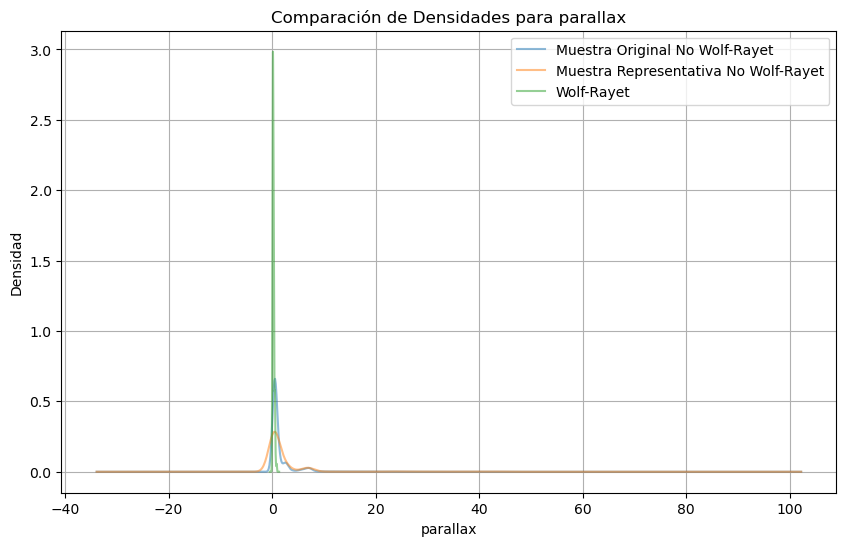

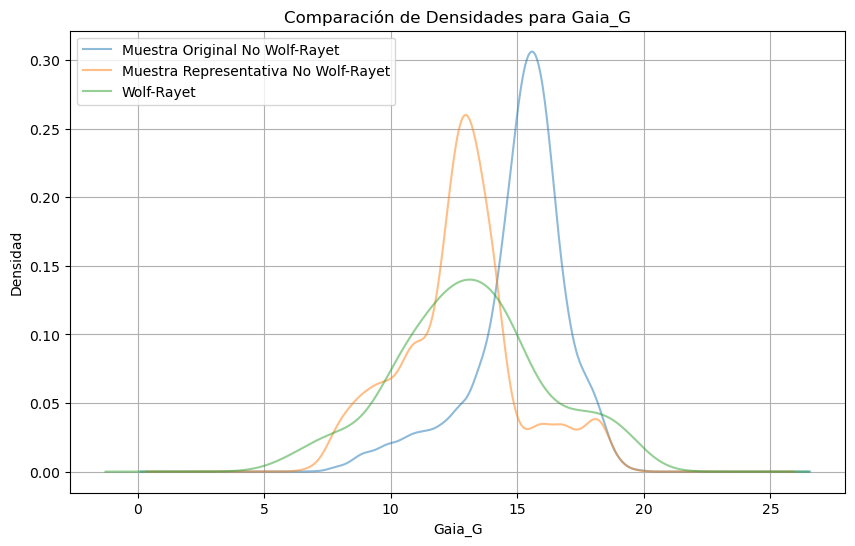

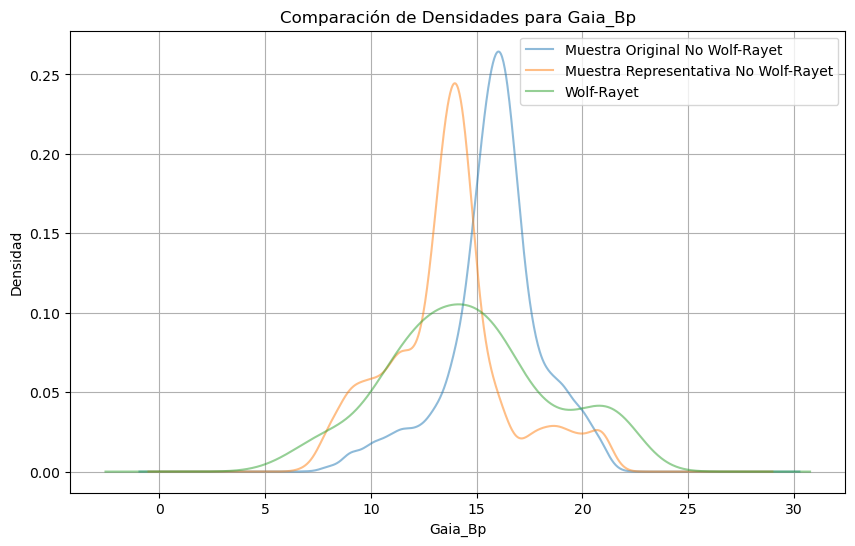

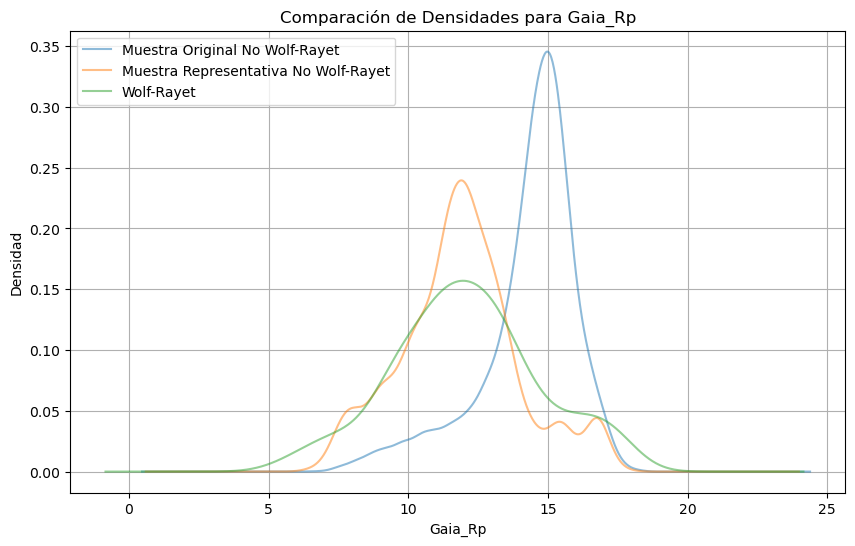

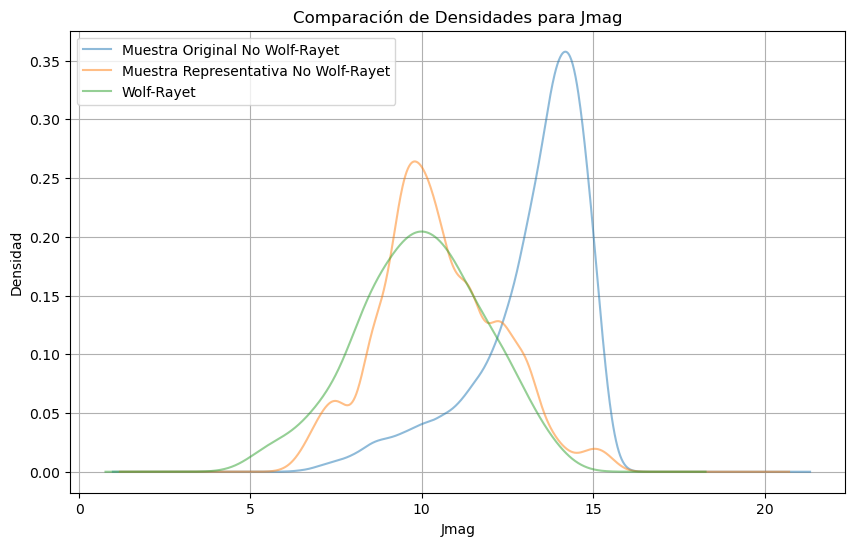

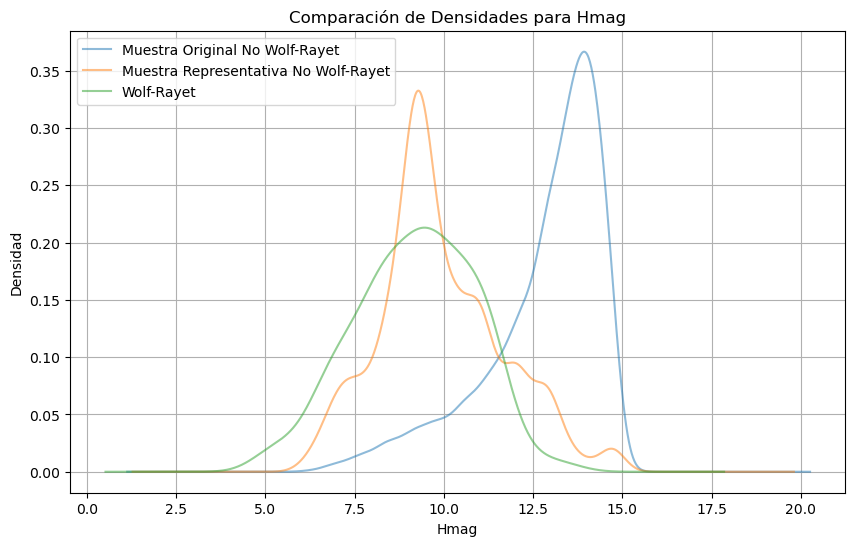

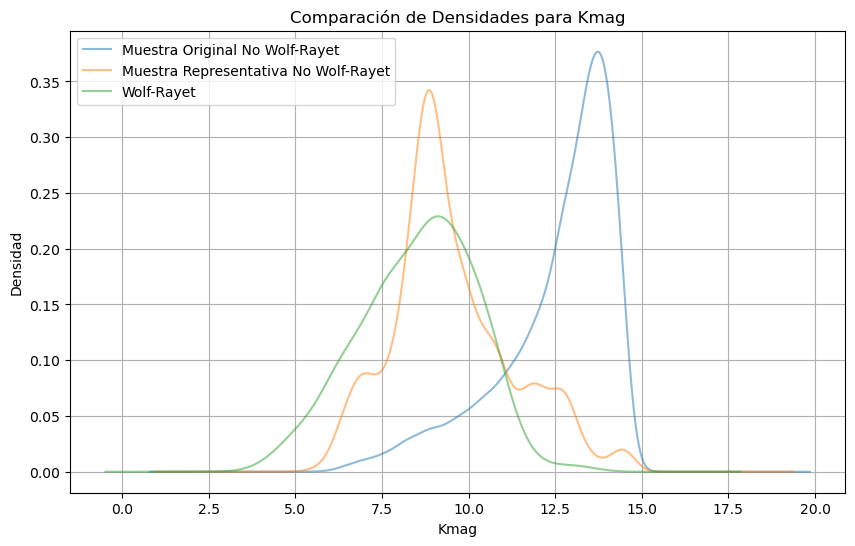

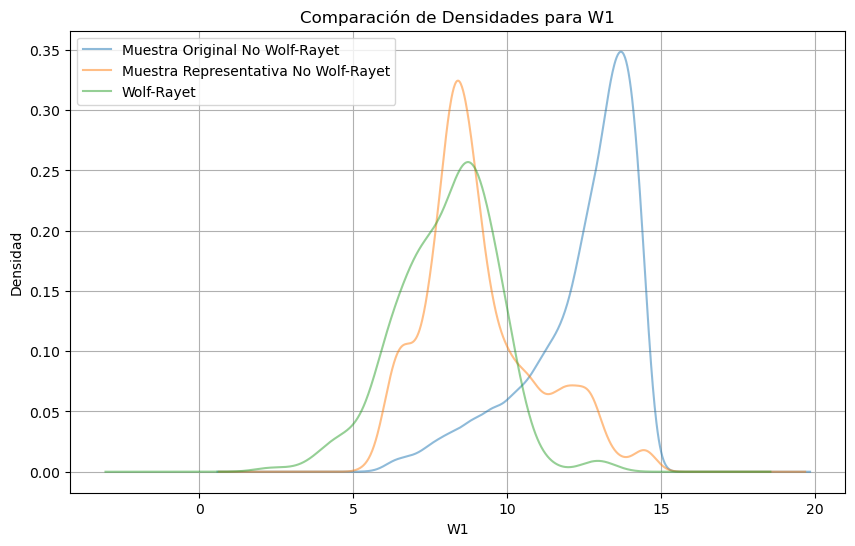

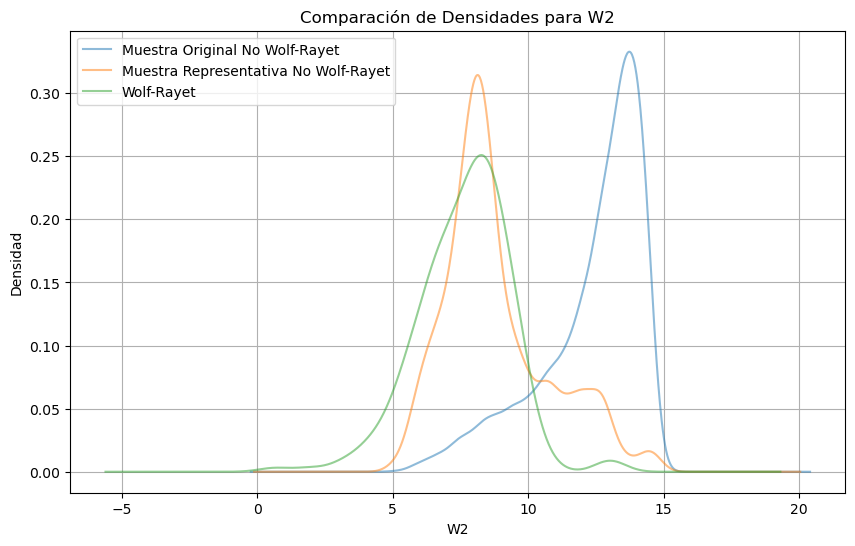

In [29]:
from scipy.stats import ks_2samp
import pickle

colores_conflictivos = ['parallax', 'Gaia_G', 'Gaia_Bp', 'Gaia_Rp', 'Jmag', 'Hmag', 'Kmag', 'W1', 
    'W2',]
def seleccionar_muestra_representativa_por_intervalos(wolfr, muestrac, colores, tamano_muestra=1000, num_intervals=10):
    indices_seleccionados = []
    ks_stats_dict = {color: [] for color in colores}
    valores_wr_dict = {color: wolfr[color].dropna() for color in colores}
    valores_no_wr_dict = {color: muestrac[color].dropna() for color in colores}
    for color in colores:
        intervals = np.linspace(valores_wr_dict[color].min(), valores_wr_dict[color].max(), num_intervals+1)
        
        for i in range(num_intervals):
            mask_no_wr = (valores_no_wr_dict[color] >= intervals[i]) & (valores_no_wr_dict[color] < intervals[i+1])
            subset_no_wr = valores_no_wr_dict[color][mask_no_wr]

            if len(subset_no_wr) > 0:
                distancias = []
                for idx in subset_no_wr.index:
                    distancia_total = 0
                    for color_inner in colores:
                        valor_no_wr = valores_no_wr_dict[color_inner].get(idx)
                        if pd.notna(valor_no_wr):
                            ks_stat, _ = ks_2samp(valores_wr_dict[color_inner], [valor_no_wr])
                            distancia_total += ks_stat
                            ks_stats_dict[color_inner].append((idx, ks_stat))
                    distancias.append((idx, distancia_total))
                distancias_ordenadas = sorted(distancias, key=lambda x: x[1])
                indices_seleccionados.extend([idx for idx, _ in distancias_ordenadas[:tamano_muestra // num_intervals]])
    muestra_representativa = muestrac.loc[indices_seleccionados]
    
    with open('modelos/ks_stats_dict2.pkl', 'wb') as f:
        pickle.dump(ks_stats_dict, f)
    
    return muestra_representativa
muestra_no_wr_representativa = seleccionar_muestra_representativa_por_intervalos(wolfr, muestrac, colores_conflictivos)
muestra_no_wr_representativa.to_csv("Archivos/Muestra/muestra_entrenamiento2.csv", index=False)

for color in colores_conflictivos:
    plt.figure(figsize=(10, 6))
    muestrac[color].dropna().plot(kind='kde', label='Muestra Original No Wolf-Rayet', alpha=0.5)
    muestra_no_wr_representativa[color].dropna().plot(kind='kde', label='Muestra Representativa No Wolf-Rayet', alpha=0.5)
    
    wolfr[color].dropna().plot(kind='kde', label='Wolf-Rayet', alpha=0.5)
    
    plt.xlabel(color)
    plt.ylabel('Densidad')
    plt.title(f'Comparación de Densidades para {color}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
muestra1 = pd.read_csv('Archivos/Muestra/muestra_entrenamiento1.csv')
muestra2 = pd.read_csv('Archivos/Muestra/muestra_entrenamiento2.csv')

muestra_entrenamiento_final = pd.concat([muestra1, muestra2]).drop_duplicates(subset='source_id')

filtro_agb_be = muestrac[muestrac['main_type'].isin(['AGB*', 'Be*'])]

filtro_agb_be = filtro_agb_be[~filtro_agb_be['source_id'].isin(muestra_entrenamiento_final['source_id'])]
muestra_entrenamiento_final = pd.concat([muestra_entrenamiento_final, filtro_agb_be]).drop_duplicates(subset='source_id')

print(f"Tamaño real de la muestra de entrenamiento final: {muestra_entrenamiento_final.shape}")
muestra_entrenamiento_final.to_csv("Archivos/Muestra/muestra_entrenamiento_final.csv", index=False)


Tamaño real de la muestra de entrenamiento final: (4813, 256)


# Graficar datos con muestra

In [4]:
wolfr_lista = pd.read_csv('Archivos/Muestra4/wolfr_rgl.csv')
muestrac_lista = pd.read_csv('Archivos/Muestra/muestra_entrenamiento_final.csv')
muestrac_lista.shape

(4813, 256)

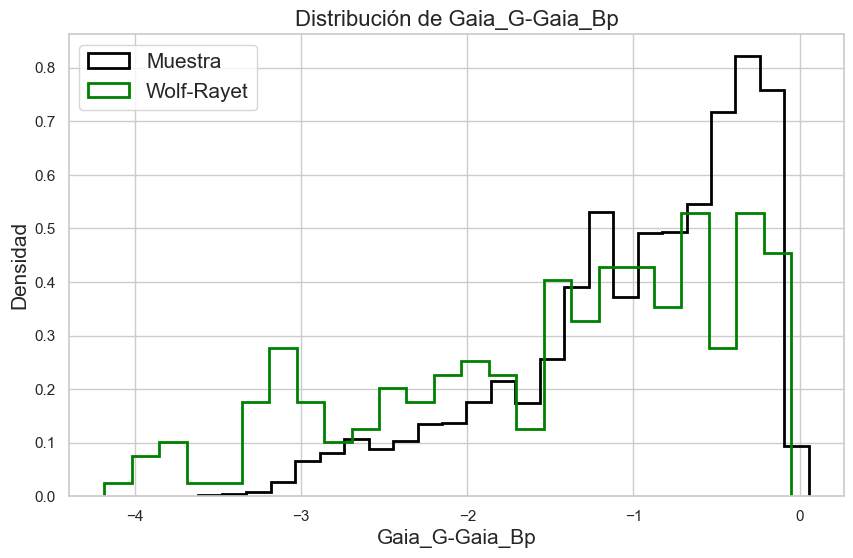

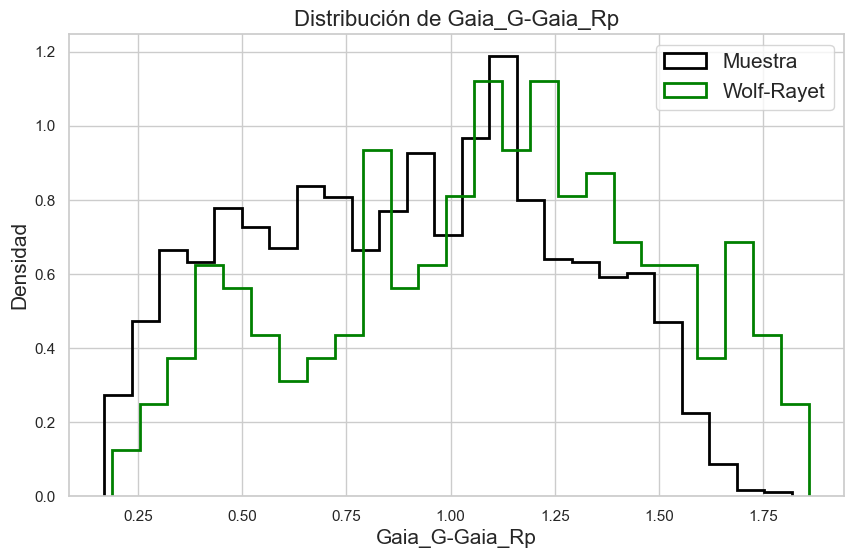

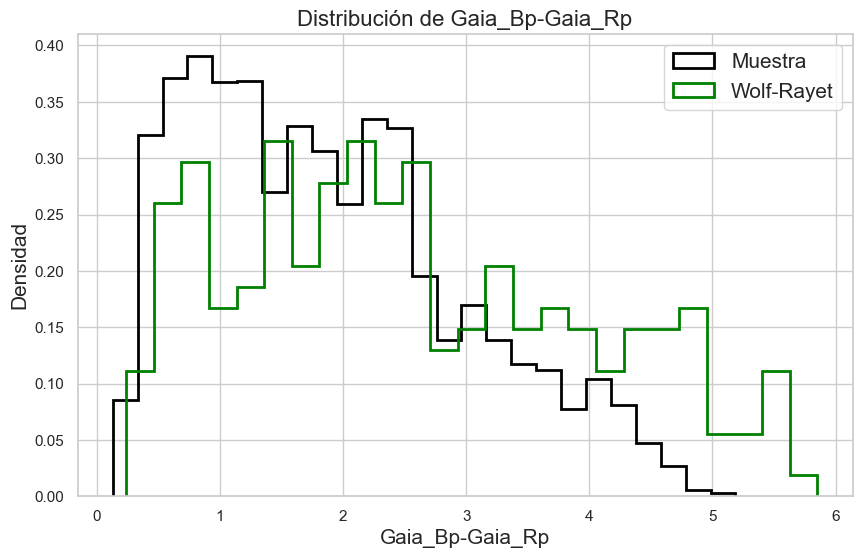

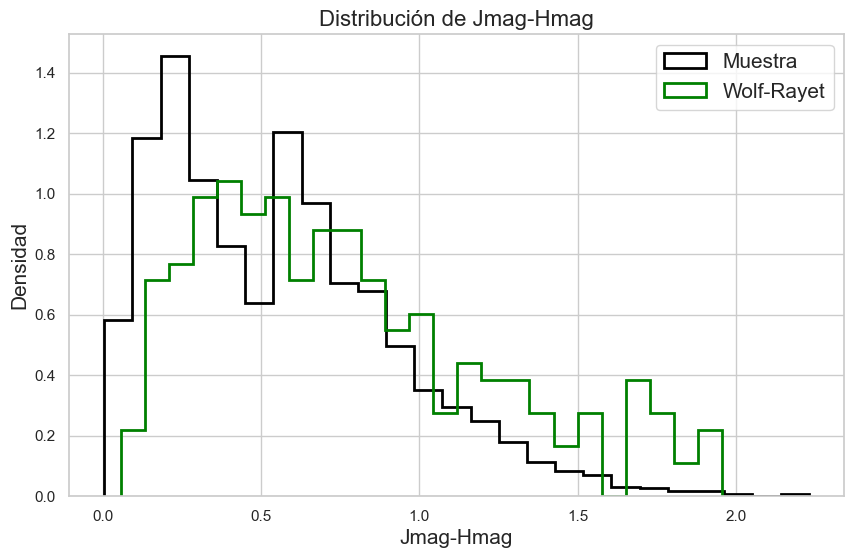

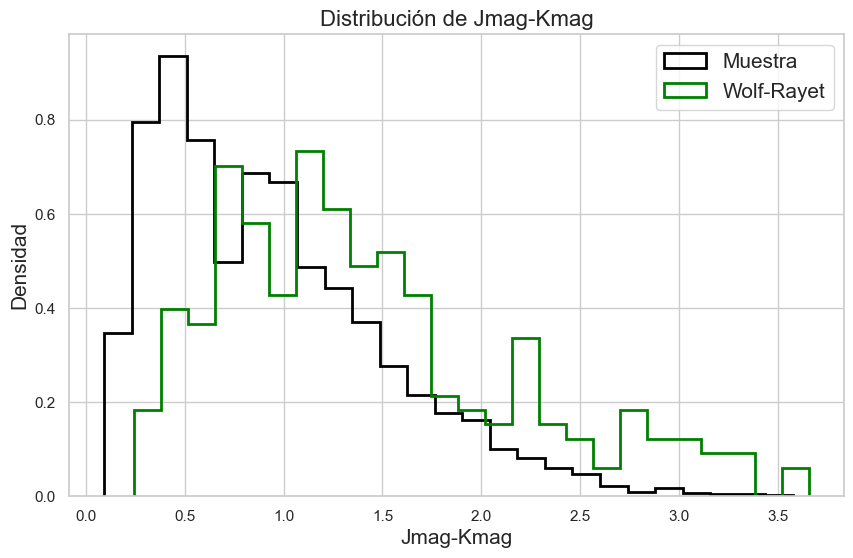

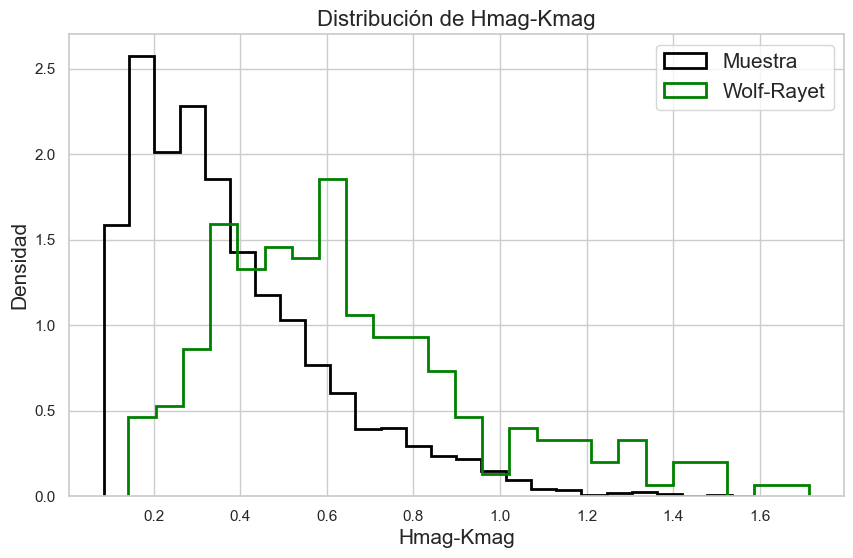

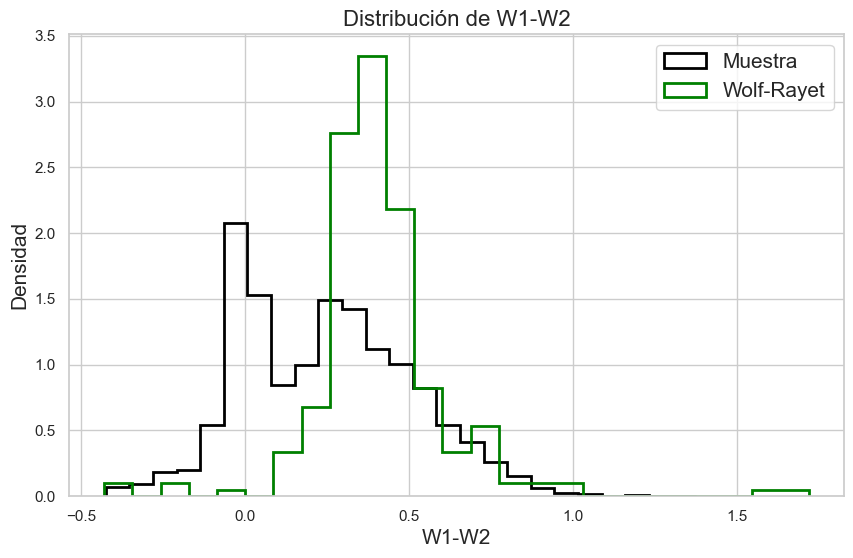

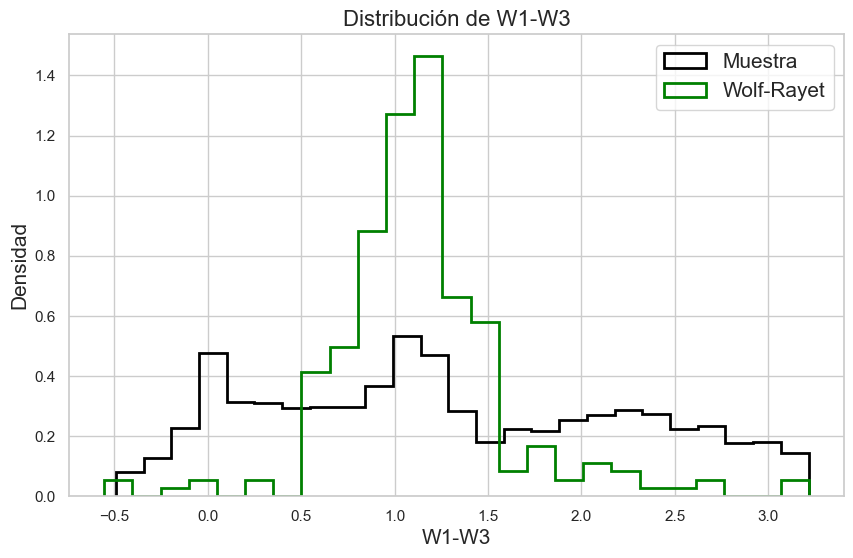

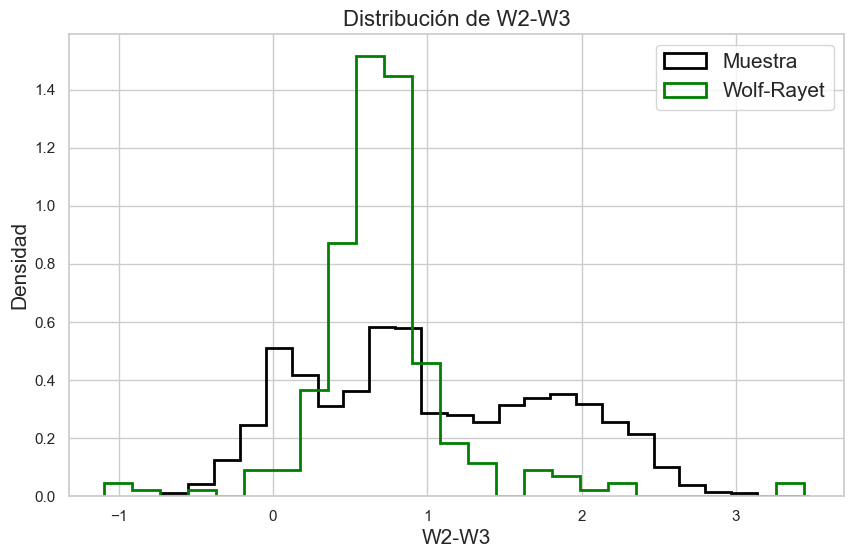

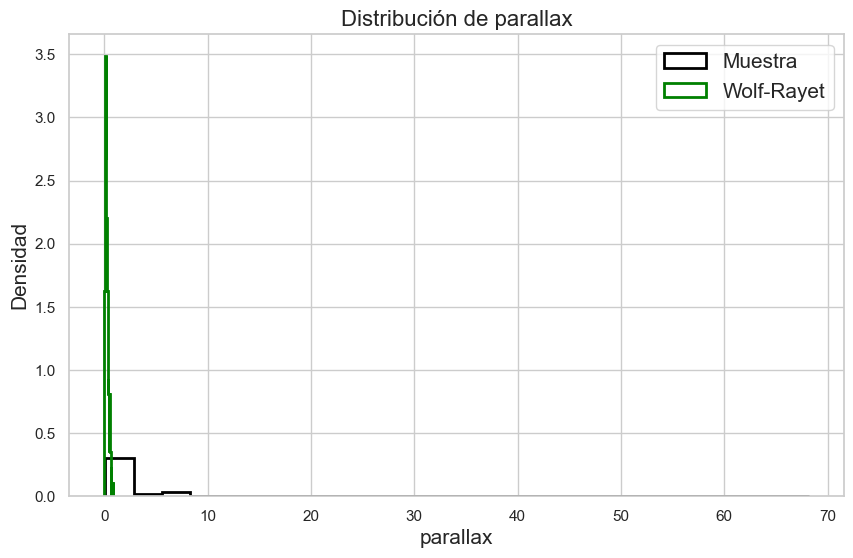

In [4]:
colores = ['Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp', 
           'Jmag-Hmag', 'Jmag-Kmag', 'Hmag-Kmag', 'W1-W2', 'W1-W3', 'W2-W3', 'parallax']

for color in colores:
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    
    plt.hist(muestrac_lista[color].dropna(), bins=25, histtype='step', density=True, label='Muestra', color='black', linewidth=2)

    plt.hist(wolfr_lista[color].dropna(), bins=25, histtype='step', density=True, label='Wolf-Rayet', color='green', linewidth=2)

    plt.title(f'Distribución de {color}', fontsize=16)
    plt.xlabel(color, fontsize=15)
    plt.ylabel('Densidad', fontsize=15)
    plt.legend(fontsize=15)

    plt.savefig(f'Graficos/histogramas_muestra/color/{color}_entrenamiento_new.png', transparent='true')
    plt.show()

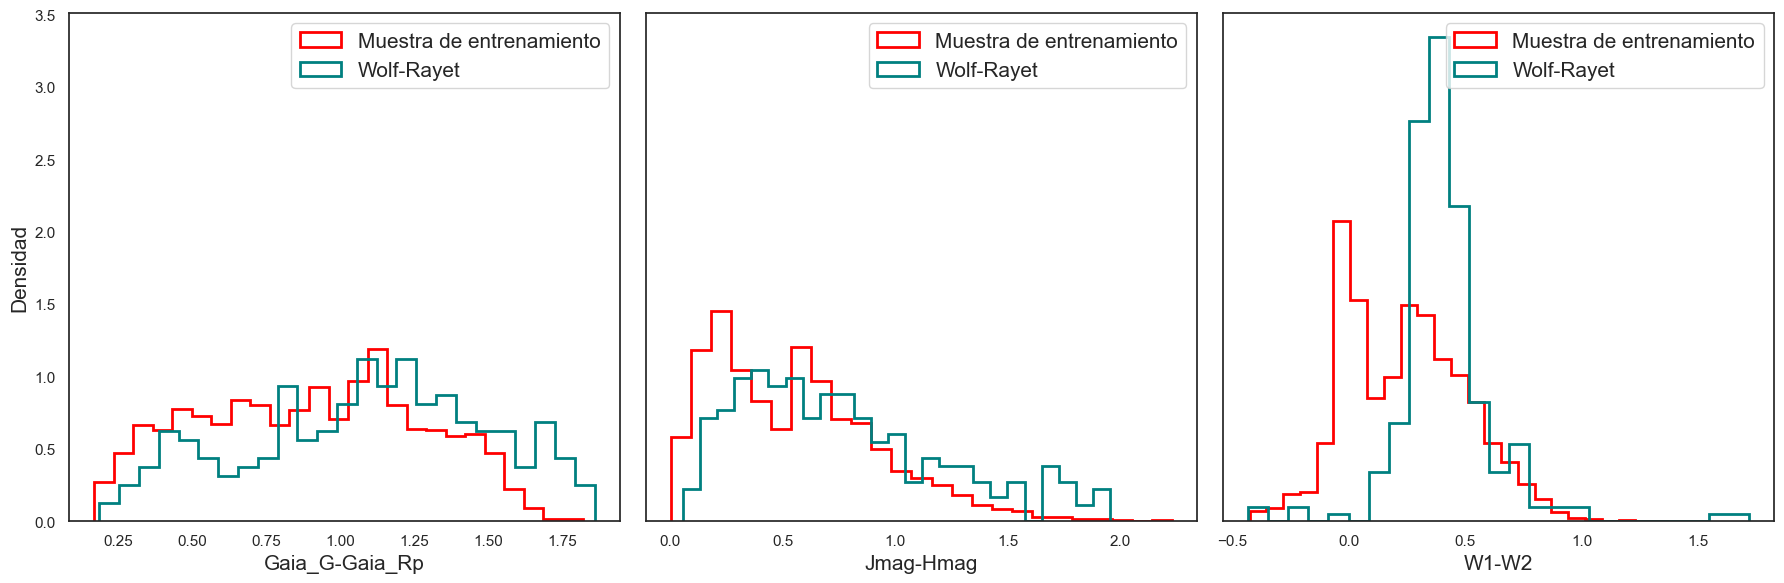

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

colores = ['Gaia_G-Gaia_Rp', 'Jmag-Hmag', 'W1-W2']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.set(style="white")

for i, color in enumerate(colores):
    axes[i].hist(muestrac_lista[color].dropna(), bins=25, histtype='step', density=True, label='Muestra de entrenamiento', color='red', linewidth=2)
    axes[i].hist(wolfr_lista[color].dropna(), bins=25, histtype='step', density=True, label='Wolf-Rayet', color='teal', linewidth=2)
    
    axes[i].set_xlabel(color, fontsize=15)
    if i == 0:  
        axes[i].set_ylabel('Densidad', fontsize=15)
    axes[i].legend(fontsize=15, loc='upper right')
plt.tight_layout()
plt.savefig('Graficos/histogramas_muestra/colores_subplots.png', transparent=True)
plt.show()


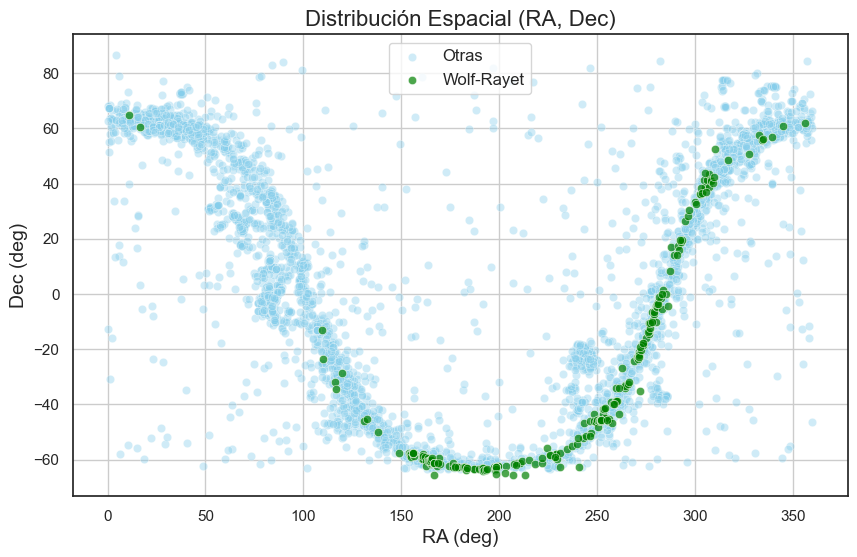

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=muestrac_lista['ra'], y=muestrac_lista['dec'], label='Otras', color='skyblue', alpha=0.4)
sns.scatterplot(x=wolfr_lista['RA_deg'], y=wolfr_lista['Dec_deg'], label='Wolf-Rayet', color='green', alpha=0.7)
plt.title('Distribución Espacial (RA, Dec)', fontsize=16)
plt.xlabel('RA (deg)', fontsize=14)
plt.ylabel('Dec (deg)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('graficos/distribucion_muestra/distribucion_espacial_RA_Dec_con_muestra.png')
plt.show()

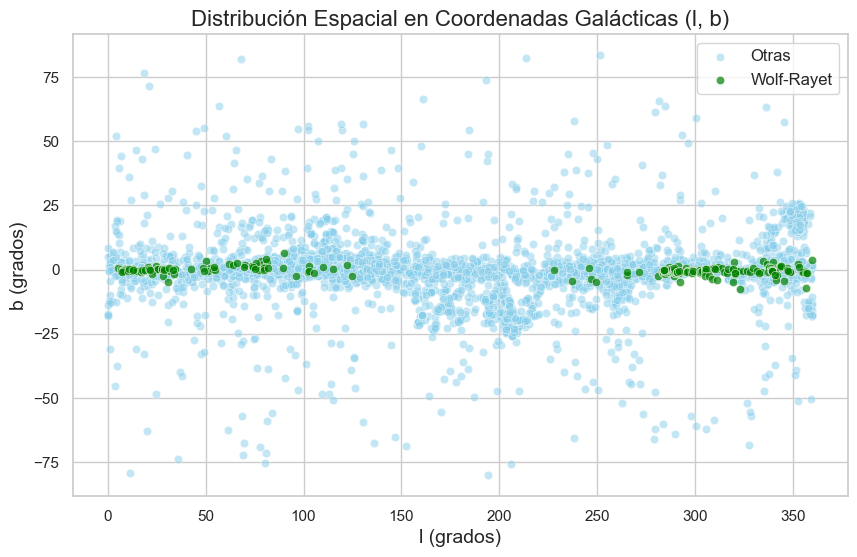

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=muestrac_lista['l'], y=muestrac_lista['b'], label='Otras', color='skyblue', alpha=0.5)
sns.scatterplot(x=wolfr_lista['Galactic Longitude (deg)'], y=wolfr_lista['Galactic Latitude (deg)'], label='Wolf-Rayet', color='green', alpha=0.7)
plt.title('Distribución Espacial en Coordenadas Galácticas (l, b)', fontsize=16)
plt.xlabel('l (grados)', fontsize=14)
plt.ylabel('b (grados)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('graficos/distribucion_muestra/distribucion_espacial_galacticas_lb_con_muestra.png')
plt.show()

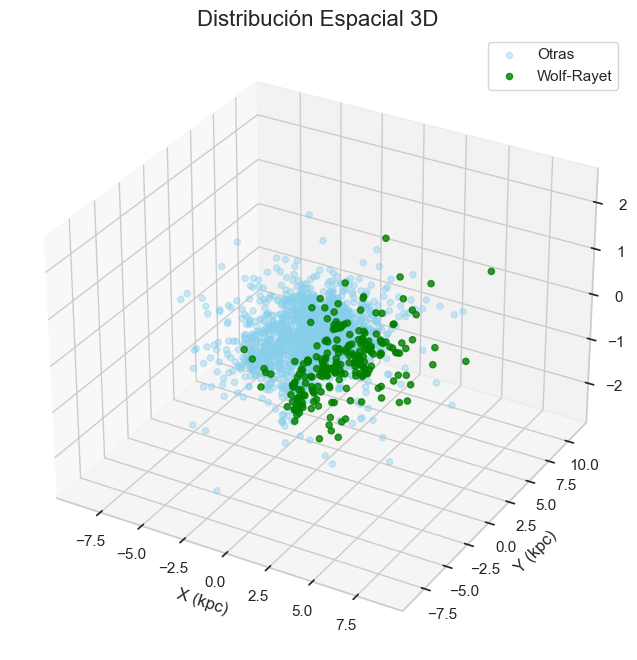

In [7]:
from mpl_toolkits.mplot3d import Axes3D
def galactic_to_cartesian(l, b, distance):
    l_rad = np.radians(l)
    b_rad = np.radians(b)
    
    x = distance * np.cos(b_rad) * np.cos(l_rad)
    y = distance * np.cos(b_rad) * np.sin(l_rad)
    z = distance * np.sin(b_rad)
    
    return x, y, z

muestrac_lista['distance (kpc)'] = muestrac_lista['distance_gspphot']/1000
x_wolfr, y_wolfr, z_wolfr = galactic_to_cartesian(wolfr_lista['Galactic Longitude (deg)'], wolfr_lista['Galactic Latitude (deg)'], wolfr_lista['Distance (kpc)'])
x_muestrac, y_muestrac, z_muestrac = galactic_to_cartesian(muestrac_lista['l'], muestrac_lista['b'], muestrac_lista['distance (kpc)'])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x_muestrac, y_muestrac, z_muestrac, label='Otras', color='skyblue', alpha=0.4)
ax.scatter(x_wolfr, y_wolfr, z_wolfr, label='Wolf-Rayet', color='green', alpha=0.8)

ax.set_title('Distribución Espacial 3D', fontsize=16)
ax.set_xlabel('X (kpc)', fontsize=12)
ax.set_ylabel('Y (kpc)', fontsize=12)
ax.set_zlabel('Z (kpc)', fontsize=12)
ax.legend()
plt.savefig('graficos/distribucion_muestra/distribucion_3D.png')
plt.show()

In [22]:


with open('Archivos/Muestra final/limits_dict.pkl', 'rb') as f:
    limits_dict = pickle.load(f)

colores_gaia = ['Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp']
colores_tmass = ['Jmag-Hmag', 'Jmag-Kmag', 'Hmag-Kmag']

sns.set(style="ticks")


combinaciones_gaia = list(combinations(colores_gaia, 2))
combinaciones_tmass = list(combinations(colores_tmass, 2))



combinaciones_totales = combinaciones_gaia + combinaciones_tmass

color_to_catalogo = {}
for color in colores_gaia:
    color_to_catalogo[color] = 'Gaia'
for color in colores_tmass:
    color_to_catalogo[color] = '2MASS'


for color1, color2 in combinaciones_totales:

    catalogo1 = color_to_catalogo.get(color1)
    catalogo2 = color_to_catalogo.get(color2)
    
    if catalogo1 != catalogo2:
        print(f"Advertencia: Los colores {color1} y {color2} pertenecen a diferentes catálogos ({catalogo1} vs {catalogo2}). Saltando esta combinación.")
        continue
    
    catalogo = catalogo1 

    key = (catalogo, color1, color2)
    if key not in limits_dict:

        key_reversed = (catalogo, color2, color1)
        if key_reversed in limits_dict:
            key = key_reversed
        else:
            print(f"Advertencia: No se encontraron límites para la combinación {key} o {key_reversed}. Saltando esta combinación.")
            continue
    
    limits = limits_dict[key]
    X_range = limits['X_range']
    Y_pred = limits['Y_pred']
    upper_limit = limits['upper_limit']
    lower_limit = limits['lower_limit']
    sigma_log = limits['sigma_log']
    
    sigma_factor = 2
    
    plt.figure(figsize=(12, 10))
    
    plt.scatter(
        muestrac_lista[color1], muestrac_lista[color2], alpha=0.7, color='red', label='Muestra entrenamiento'
    )
    
    plt.scatter(
        wolfr_lista[color1], wolfr_lista[color2], 
        s=50, alpha=1, label='Wolf-Rayet', 
        color='teal', edgecolor='black', linewidth=0.5
    )

    plt.plot(X_range, Y_pred, color='black', label='Regresión Lineal')
    
    plt.fill_between(X_range, lower_limit, upper_limit, color='gray', alpha=0.2, label=f'±{sigma_factor}σ')
    
    plt.xlabel(color1, fontsize=20)
    plt.ylabel(color2, fontsize=20)
    plt.legend(loc="best", markerscale=1.5, fontsize=25)
    
    nombre_archivo = f'graficos/color-color_muestra/{color1}_vs_{color2}.png'
    plt.savefig(nombre_archivo, dpi=300, transparent=True)
    plt.close()

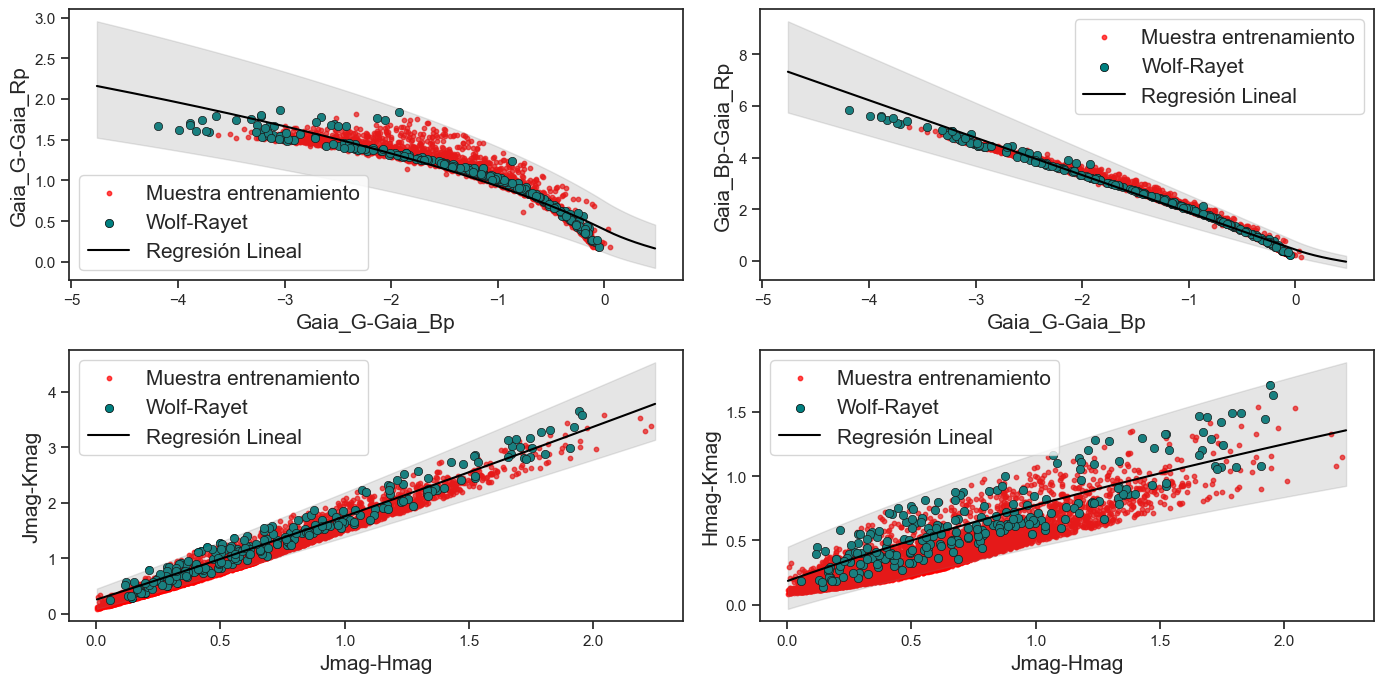

In [5]:


with open('Archivos/Muestra final/limits_dict.pkl', 'rb') as f:
    limits_dict = pickle.load(f)

colores_gaia = ['Gaia_G-Gaia_Bp', 'Gaia_G-Gaia_Rp', 'Gaia_Bp-Gaia_Rp']
colores_tmass = ['Jmag-Hmag', 'Jmag-Kmag', 'Hmag-Kmag']

sns.set(style="ticks")
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12})

combinaciones_gaia = list(combinations(colores_gaia, 2))
combinaciones_tmass = list(combinations(colores_tmass, 2))
combinaciones_totales = combinaciones_gaia[:2] + combinaciones_tmass[:2]  

color_to_catalogo = {c: 'Gaia' for c in colores_gaia}
color_to_catalogo.update({c: '2MASS' for c in colores_tmass})

fig, axes = plt.subplots(2, 2, figsize=(14, 7), tight_layout=True)  
sigma_factor = 2  

for i, (color1, color2) in enumerate(combinaciones_totales):
    catalogo = color_to_catalogo[color1]
    key = (catalogo, color1, color2)
    
    if key not in limits_dict:
        key = (catalogo, color2, color1)
    
    limits = limits_dict[key]
    X_range = limits['X_range']
    Y_pred = limits['Y_pred']
    upper_limit = limits['upper_limit']
    lower_limit = limits['lower_limit']
    
    ax = axes[i // 2, i % 2] 
    
    ax.scatter(
        muestrac_lista[color1], muestrac_lista[color2],
        alpha=0.7, color='red', s=10, label='Muestra entrenamiento'
    )
    ax.scatter(
        wolfr_lista[color1], wolfr_lista[color2],
        color='teal', edgecolor='black', linewidth=0.5, label='Wolf-Rayet'
    )
    ax.plot(X_range, Y_pred, color='black', label='Regresión Lineal')
    ax.fill_between(X_range, lower_limit, upper_limit, color='gray', alpha=0.2)
    ax.set_xlabel(color1, fontsize=15)
    ax.set_ylabel(color2, fontsize=15)
    ax.legend(loc="best", fontsize=15)

plt.savefig('figura_color_color_subplots_achatada.png', dpi=300, bbox_inches='tight')
plt.show()
